## ARIMA model forecast

In [32]:
# import
%pylab inline
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from statsmodels.tsa.arima_model import ARIMA

Populating the interactive namespace from numpy and matplotlib


<Figure size 864x432 with 0 Axes>

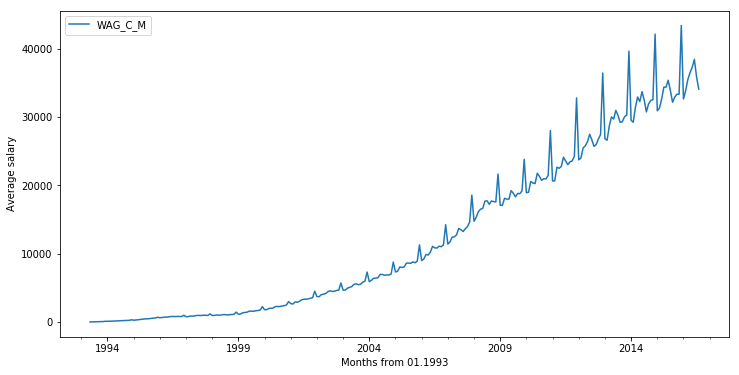

In [34]:
# read the data
WAG = pd.read_csv('data\salary.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True,encoding='cp1251',engine='python')
plt.figure(figsize(12,6))
WAG.plot()
plt.ylabel(u'Average salary')
plt.xlabel(u'Months from 01.1993')
plt.show()

In [35]:
WAG.WAG_C_M.head()

month
1993-05-01    37.5
1993-06-01    47.4
1993-07-01    56.0
1993-08-01    65.4
1993-09-01    80.9
Name: WAG_C_M, dtype: float64

Dickey-Fuller test: p=0.991667
Student test: p=0.000000


<Figure size 1080x720 with 0 Axes>

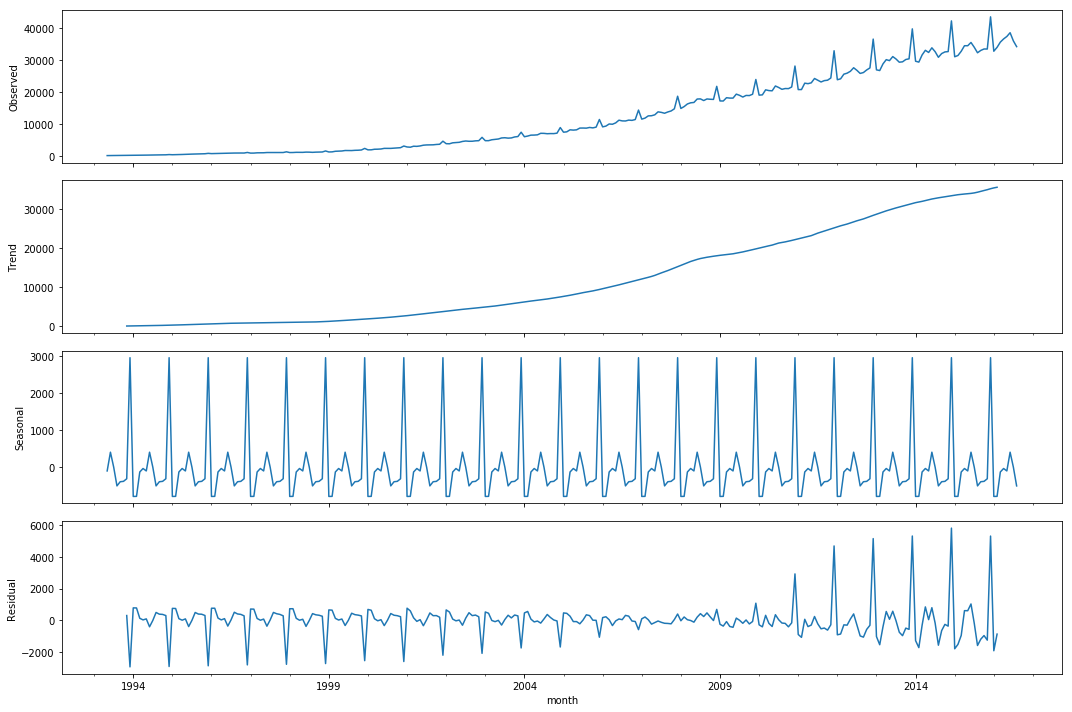

In [36]:
# ts decomposition
# Diki-Fuller test to check stationarity

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M)[1])
print("Student test: p=%f" % stats.ttest_1samp(WAG.WAG_C_M, 0)[1])

Best Box-Cox parameter: 0.257063
Dickey-Fuller test: p=0.688484


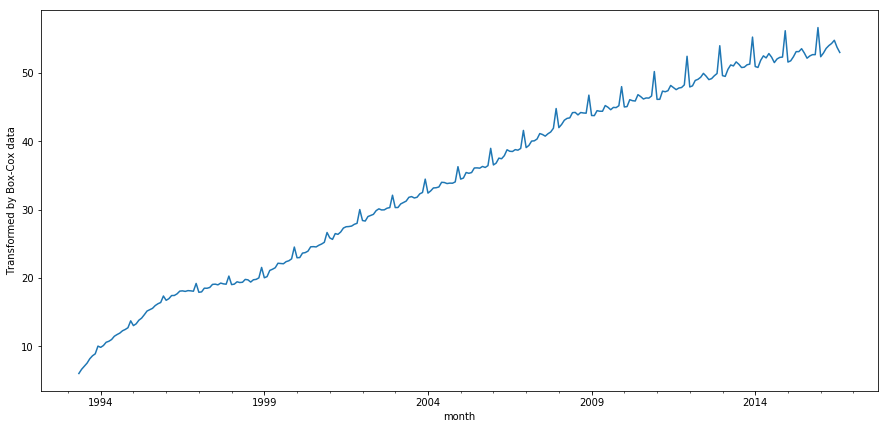

In [37]:
# Box–Cox transformation

WAG['WAG_C_M_box'], lmbda = stats.boxcox(WAG.WAG_C_M)
plt.figure(figsize(15,7))
WAG.WAG_C_M_box.plot()
plt.ylabel('Transformed by Box-Cox data')
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box)[1])

Dickey-Fuller test: p=0.033416


<Figure size 1080x720 with 0 Axes>

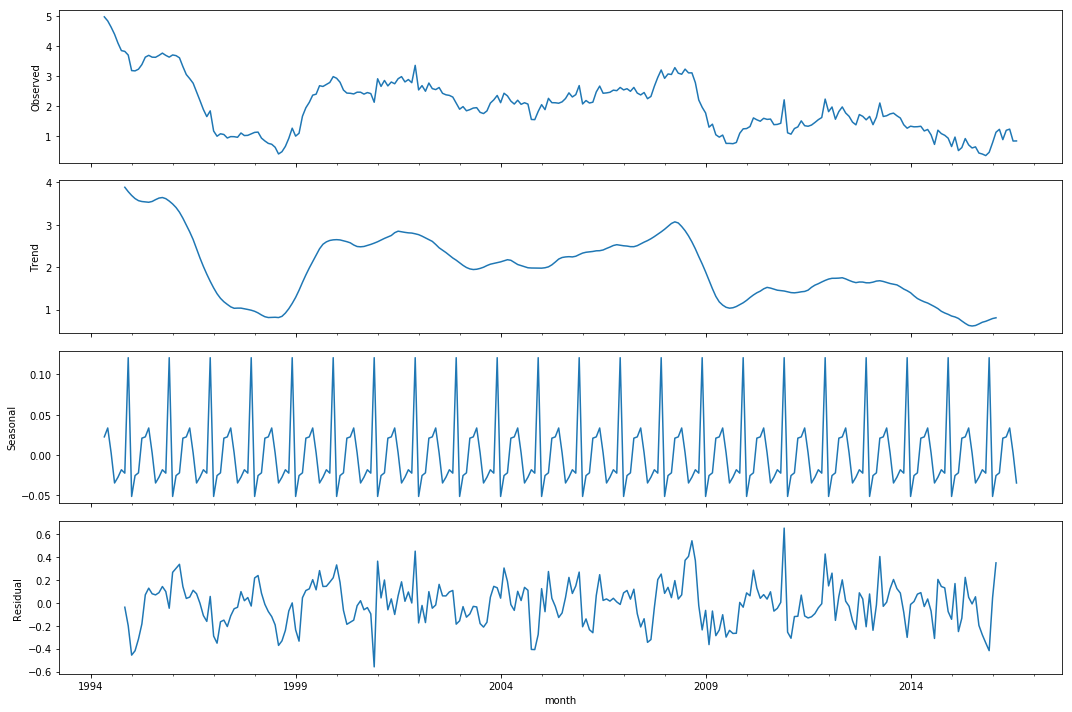

In [38]:
# season-based differentition for the 12 months - 12 step shift

WAG['WAG_C_M_box_diff']  = WAG.WAG_C_M_box - WAG.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M_box_diff[12:]).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box_diff[12:])[1])

Dickey-Fuller test: p=0.000000791458638


<Figure size 1080x720 with 0 Axes>

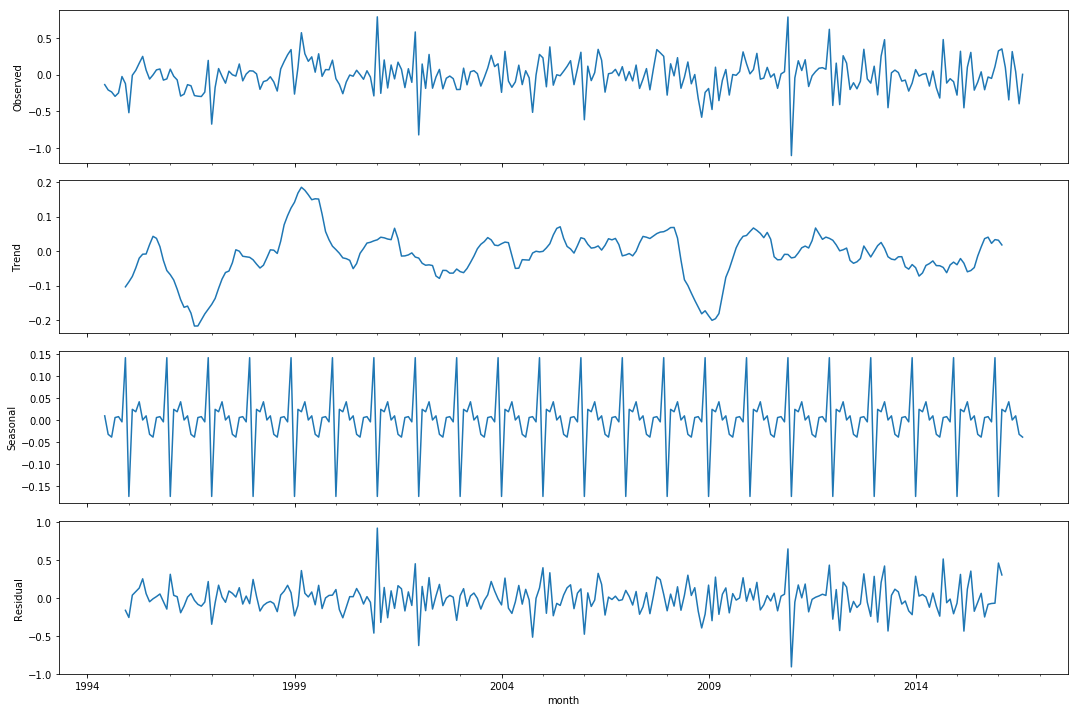

In [39]:
# additional one-step differencing

WAG['WAG_C_M_box_diff2'] = WAG.WAG_C_M_box_diff - WAG.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M_box_diff2[13:]).plot()
print("Dickey-Fuller test: p=%.15f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box_diff2[13:])[1])

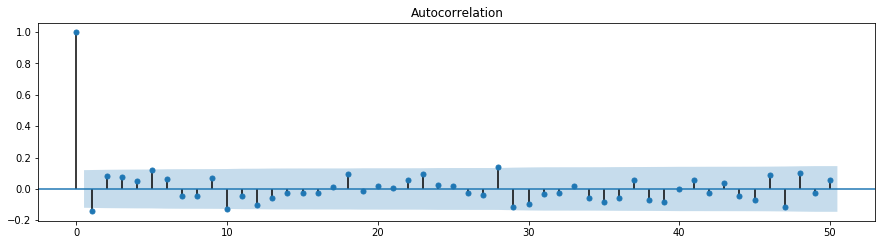

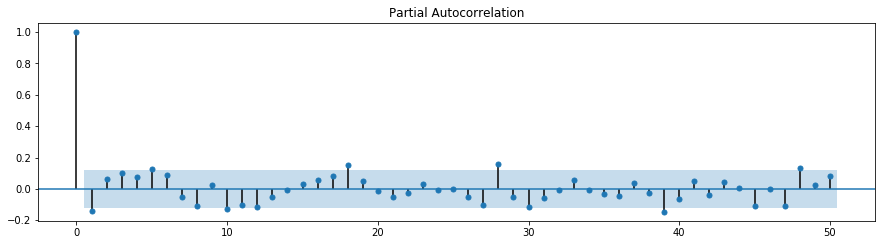

In [40]:
# autocorrelation and partial autocorrelation

plt.figure(figsize(15,8))

# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(WAG.WAG_C_M_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(WAG.WAG_C_M_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

In [41]:
# SARIMA parameters:

ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print (u"Models to analyse by AIC:", len(parameters_list))

Models to analyse by AIC: 72


In [43]:
WAG.WAG_C_M_box.head()

month
1993-05-01    5.986007
1993-06-01    6.599071
1993-07-01    7.058410
1993-08-01    7.503958
1993-09-01    8.144275
Name: WAG_C_M_box, dtype: float64

In [44]:
results = []
best_aic = float("inf")

# ignore warnings 
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(WAG.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
            continue
    aic = model.aic

    # save best model, aic, parameters
    if (aic < best_aic):
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    

In [45]:
model.aic

-52.08255524989495

In [46]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
69  (5, 4, 1, 0) -54.255784
59  (4, 5, 1, 0) -53.149475
71  (5, 5, 1, 0) -52.082555
68  (5, 4, 0, 0) -51.560310
29  (2, 2, 1, 0) -49.074862


In [47]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  280
Model:             SARIMAX(5, 1, 4)x(1, 1, 0, 12)   Log Likelihood                  38.128
Date:                            Mon, 25 May 2020   AIC                            -54.256
Time:                                    12:29:39   BIC                            -14.796
Sample:                                05-01-1993   HQIC                           -38.405
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6921      0.053     13.061      0.000       0.588       0.796
ar.L2         -0.4345      0.081   

Student test: p=0.234496
Dickey-Fuller test: p=0.0000000000000000000000000


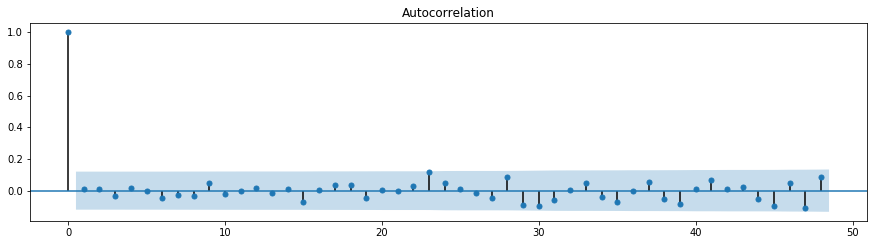

In [48]:
# residuals
plt.figure(figsize(15,8))
plt.plot(best_model.resid[13:])
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].squeeze(), lags=48, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

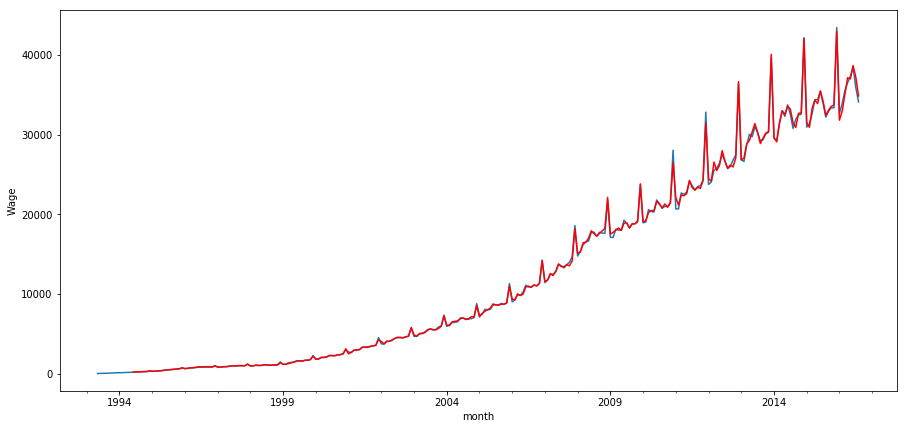

In [49]:
#inverse Box–Cox transformation

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)
    
# visualise and compare  
WAG['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
WAG.WAG_C_M.plot()
WAG.model[13:].plot(color='r')
plt.ylabel('Wage')
pylab.show()


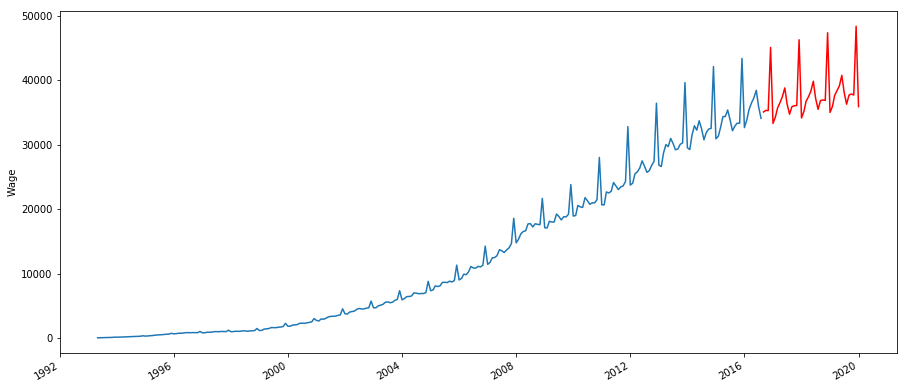

In [50]:
WAG2 = WAG[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,48)]
future = pd.DataFrame(index=date_list, columns= WAG2.columns)
WAG2 = pd.concat([WAG2, future])
WAG2['forecast'] = invboxcox(best_model.predict(start=280, end=320), lmbda)

plt.figure(figsize(15,7))
WAG2.WAG_C_M.plot()
WAG2.forecast.plot(color='r')
plt.ylabel('Wage')
pylab.show()

In [51]:
# quality metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("MSE = ", mean_squared_error(WAG.WAG_C_M[13:],WAG.model[13:]))
print("MAE = ", mean_absolute_error(WAG.WAG_C_M[13:],WAG.model[13:]))
print("MAPE = ", round(np.mean(np.abs(WAG.WAG_C_M[13:]-WAG.model[13:])/WAG.WAG_C_M[13:])*100,3))
print("R^2 = ", r2_score(WAG.WAG_C_M[13:],WAG.model[13:]))

MSE =  91172.14869877032
MAE =  169.79243099524814
MAPE =  1.722
R^2 =  0.9993602449603203
